In [1]:
from typing import List
import pandas as pd
pd.set_option("display.max_columns",None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Store.csv")

In [3]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.0,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.0,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.0,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.0,0,NaN
4,1456,2013-01-01,5,BOOKS,0.0,0,NaN


In [4]:
cols_drop = ["id","store_nbr","dcoilwtico"]
df = df.drop(cols_drop,axis=1)

In [5]:
df["date"] = pd.to_datetime(df["date"],format="%Y-%m-%d")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         55572 non-null  datetime64[ns]
 1   family       55572 non-null  object        
 2   sales        55572 non-null  float64       
 3   onpromotion  55572 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [6]:
df.head()

,date,family,sales,onpromotion
0,2013-01-01,AUTOMOTIVE,0.0,0
1,2013-01-01,BABY CARE,0.0,0
2,2013-01-01,BEAUTY,0.0,0
3,2013-01-01,BEVERAGES,0.0,0
4,2013-01-01,BOOKS,0.0,0


In [7]:
def filter_family(df: pd.DataFrame,family:str) -> pd.DataFrame:
    filtered_df = df[df["family"]==family].reset_index(drop=True)
    return filtered_df


def adfuller_test(df : pd.Series, p: int) -> None:
    if p == 0:
        result = adfuller(df.dropna())
        print("No Differencing")
        print(f"p-value : {result[1]}")
    else:
        diff_df = df.copy()
        for i in range(p + 1):
            if i == 0:
                result = adfuller(diff_df.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")
            else:
                diff_df = diff_df.diff().dropna().reset_index(drop=True)
                result = adfuller(diff_df.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")


In [8]:
df_personal_care = filter_family(df,"PERSONAL CARE")
df_personal_care.head()

,date,family,sales,onpromotion
0,2013-01-01,PERSONAL CARE,0.0,0
1,2013-01-02,PERSONAL CARE,427.0,0
2,2013-01-03,PERSONAL CARE,312.0,0
3,2013-01-04,PERSONAL CARE,265.0,0
4,2013-01-05,PERSONAL CARE,330.0,0


<Axes: xlabel='date'>

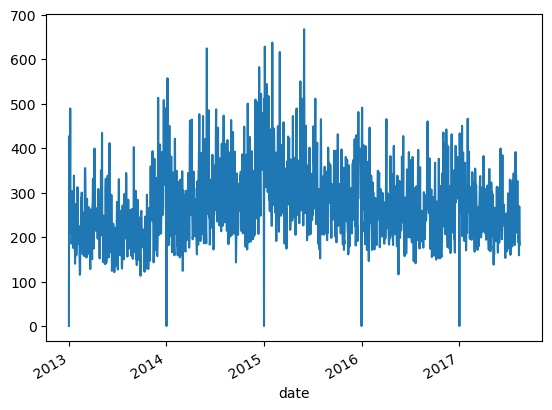

In [9]:
df_personal_care.set_index("date").sales.plot()

<Axes: xlabel='date'>

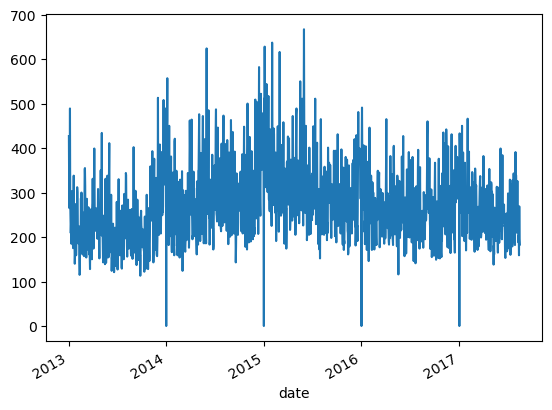

In [10]:
df_personal_care.iloc[1:,:].reset_index(drop=True).set_index("date").sales.plot()

<Axes: xlabel='date'>

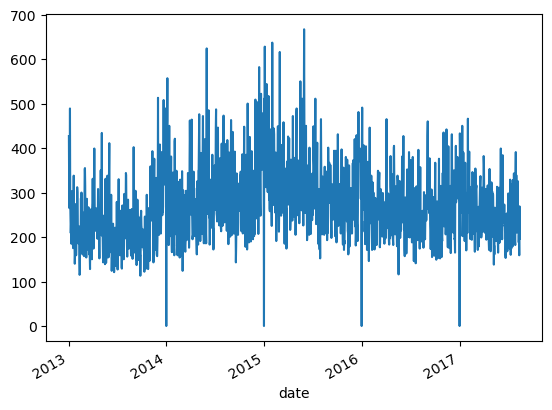

In [12]:
df_personal_care = df_personal_care.iloc[1:-1,:].reset_index(drop=True)
df_personal_care.set_index("date").sales.plot()

<Axes: xlabel='date'>

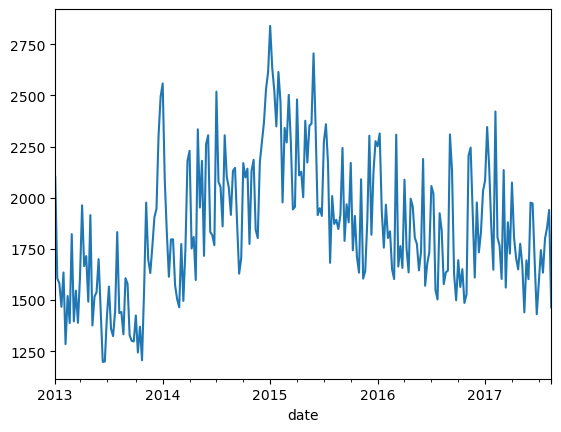

In [13]:
df_personal_care.set_index("date").sales.resample("W-MON").sum().plot()

In [14]:
df_personal_care = df_personal_care.set_index("date").sales.resample("W-MON").sum()
df_personal_care = np.log(df_personal_care)
df_personal_care.head()

date
2013-01-07    7.650645
2013-01-14    7.381502
2013-01-21    7.366445
2013-01-28    7.290975
2013-02-04    7.399398
Freq: W-MON, Name: sales, dtype: float64

In [15]:
df_personal_care.index = pd.date_range(start=df_personal_care.index.min(), end=df_personal_care.index.max(), freq='W-MON')

In [16]:
adfuller_test(df_personal_care,4)

Differencing level 0
p-value : 0.35244377102386515
Differencing level 1
p-value : 1.1562074128486646e-08
Differencing level 2
p-value : 1.1366004408174125e-09
Differencing level 3
p-value : 4.203196800139962e-18
Differencing level 4
p-value : 3.859551754027254e-21


<Axes: >

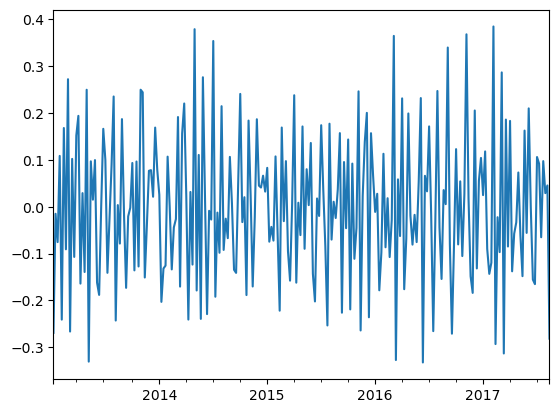

In [17]:
df_personal_care.diff().dropna().plot()

<Axes: >

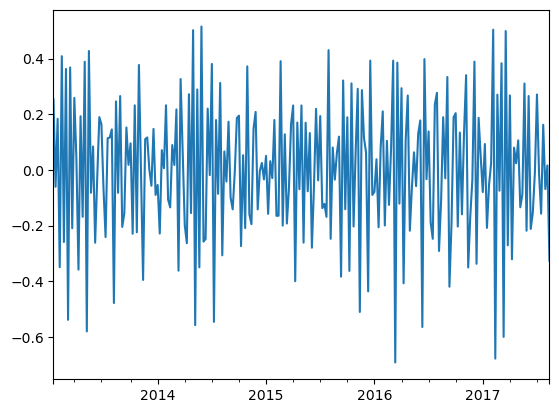

In [18]:
df_personal_care.diff().diff().dropna().plot()

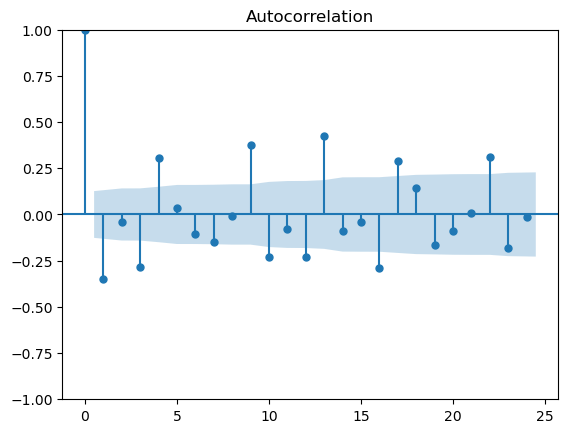

In [27]:
plot_acf(df_personal_care.diff().dropna());

q = 1

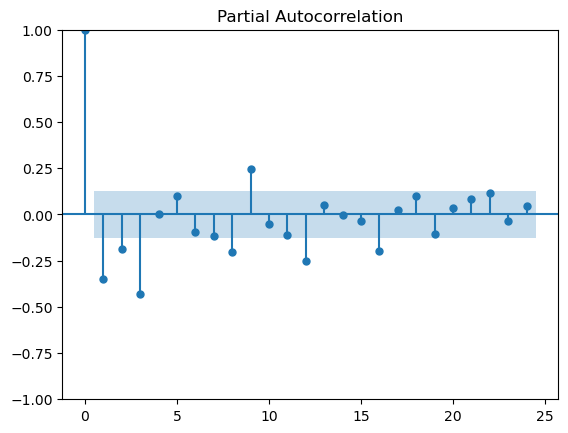

In [29]:
plot_pacf(df_personal_care.diff().dropna());

p = 3

In [30]:
train_date = int(len(df_personal_care)*0.98)
train_date

236

In [31]:
df_personal_care.iloc[:train_date]

2013-01-07    7.650645
2013-01-14    7.381502
2013-01-21    7.366445
2013-01-28    7.290975
2013-02-04    7.399398
                ...   
2017-06-12    7.586804
2017-06-19    7.431300
2017-06-26    7.266129
2017-07-03    7.372118
2017-07-10    7.463937
Freq: W-MON, Name: sales, Length: 236, dtype: float64

In [32]:
train_data = df_personal_care.iloc[:train_date]
test_data = df_personal_care.iloc[train_date:]

In [33]:
arima_model_1  = ARIMA(train_data, order=(3,1,1))
model_1 = arima_model_1.fit()

print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  236
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 155.441
Date:                Tue, 18 Jun 2024   AIC                           -300.883
Time:                        17:07:57   BIC                           -283.585
Sample:                    01-07-2013   HQIC                          -293.909
                         - 07-10-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4943      0.149     -3.328      0.001      -0.785      -0.203
ar.L2         -0.3802      0.101     -3.780      0.000      -0.577      -0.183
ar.L3         -0.4462      0.077     -5.790      0.0

In [34]:
train_pred = model_1.predict(start=train_data.index.min(), end=train_data.index.max(),typ="linear")
train_pred = pd.DataFrame(train_pred)
train_pred

,predicted_mean
2013-01-07,0.000000
2013-01-14,7.650644
2013-01-21,7.477345
2013-01-28,7.425886
2013-02-04,7.456893
...,...
2017-06-12,7.429277
2017-06-19,7.528880
2017-06-26,7.417837
2017-07-03,7.411727


In [42]:
predict_train = pd.merge(train_data,train_pred,left_index=True, right_index=True)

rmse_score = mse(np.exp(predict_train.sales), np.exp(predict_train.predicted_mean),squared=False)
print(f"RMSE of Training Set: {rmse_score}")

from sklearn.metrics import mean_absolute_percentage_error as mape
mape_train = mape(np.exp(predict_train.sales), np.exp(predict_train.predicted_mean)) * 100
print(f"MAPE of Training Set: {mape_train.round(2)}")

RMSE of Training Set: 273.5886229736624
MAPE of Training Set: 10.44


In [37]:
test_pred = model_1.predict(start=test_data.index.min(), end=test_data.index.max(),typ="linear")
test_pred = pd.DataFrame(test_pred)
test_pred

,predicted_mean
2017-07-17,7.451676
2017-07-24,7.375534
2017-07-31,7.376862
2017-08-07,7.410623
2017-08-14,7.427406


In [43]:
predict_test = pd.merge(test_data,test_pred,left_index=True, right_index=True)
display(predict_test)


rmse_score = mse(np.exp(predict_test.sales), np.exp(predict_test.predicted_mean),squared=False)
print(f"RMSE of Test Set: {rmse_score}")

mape_test = mape(np.exp(predict_test.sales), np.exp(predict_test.predicted_mean)) * 100
print(f"MAPE of Test Set {mape_test.round(2)}")

,sales,predicted_mean
2017-07-17,7.398786,7.451676
2017-07-24,7.496097,7.375534
2017-07-31,7.525101,7.376862
2017-08-07,7.570443,7.410623
2017-08-14,7.288928,7.427406


RMSE of Test Set: 221.06744488942593
MAPE of Test Set 12.04


In [39]:
def plot_predictions(predict_train: pd.DataFrame, predict_test: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 6))
    
    
    plt.plot(predict_train.index, np.exp(predict_train['sales']), color='green', label='Train Actual')
    plt.plot(predict_train.index, np.exp(predict_train['predicted_mean']), color='red', label='Train Predicted')
    
 
    plt.plot(predict_test.index, np.exp(predict_test['sales']), color='yellow', label='Test Actual')
    plt.plot(predict_test.index, np.exp(predict_test['predicted_mean']), color='blue', label='Test Predicted')
    
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Actual vs Predicted Sales')
    plt.legend()
    plt.show()

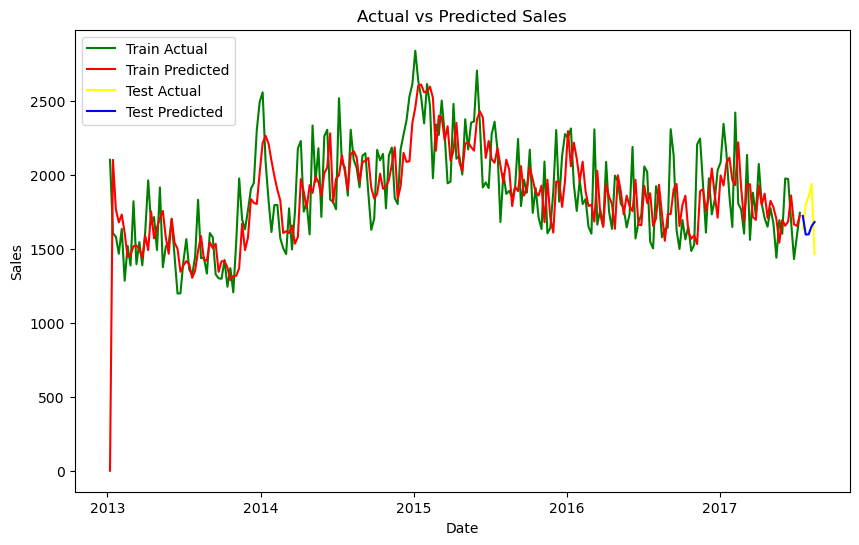

In [40]:
plot_predictions(predict_train, predict_test)